The following is from this (https://qiskit.github.io/qiskit-aer/tutorials/1_aersimulator.html) tutorial to test Qiskit Aer.

In [55]:
import numpy as np

# Import Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
import time

In [34]:
simulator = AerSimulator()

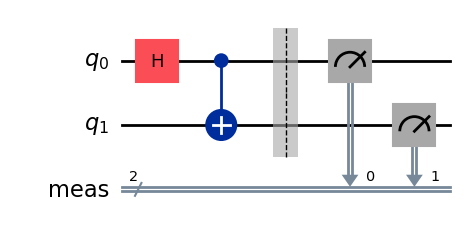

In [35]:
# Create circuit
circ = QuantumCircuit(2)
circ.h(0)
circ.cx(0, 1)
circ.measure_all()
circ.draw("mpl")

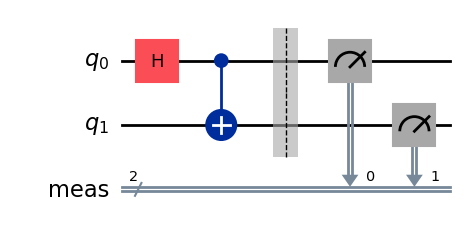

In [36]:
# Transpile for simulator
simulator = AerSimulator()
circl = transpile(circ, simulator)
circl.draw("mpl")

Okay now with that, below I will try to implement my own circuit:

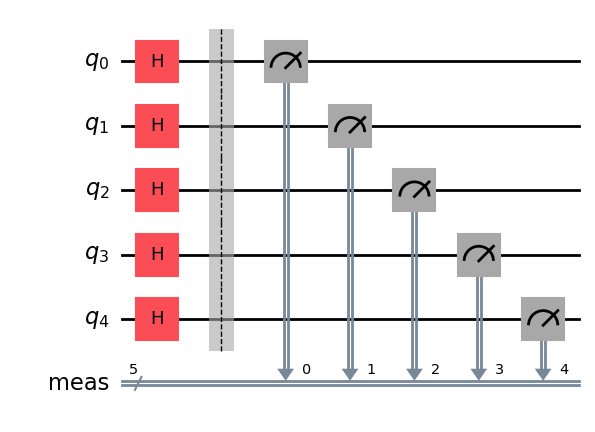

In [37]:
def super_hadamard(circuit, start_q, end_q): # uses qubit index, so start at q0
    for qubit in range(start_q, end_q+1):
        circuit.h(qubit)

hadamard_tester = QuantumCircuit(5)
super_hadamard(hadamard_tester, 0,4) 
hadamard_tester.measure_all()
hadamard_tester.draw("mpl")

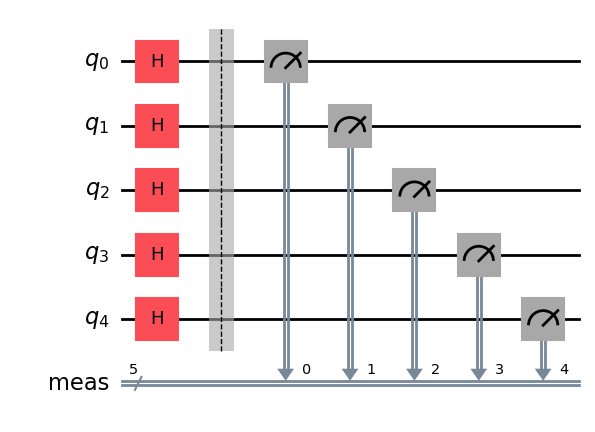

In [39]:
hadamard_circuit = transpile(hadamard_tester,simulator)
hadamard_circuit.draw("mpl")

This trial took 0.005077838897705078 seconds


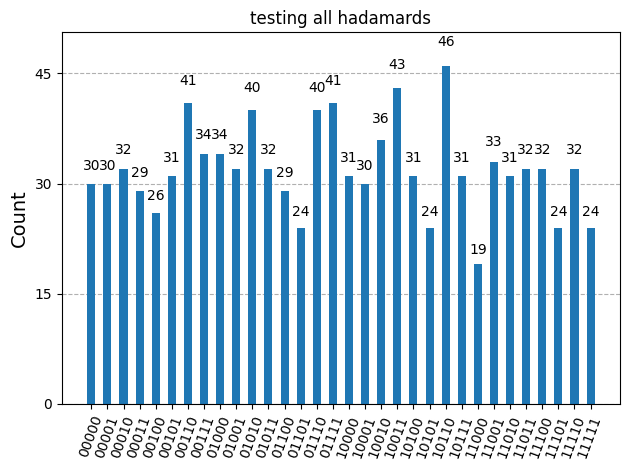

In [62]:
start = time.time()

job = simulator.run(hadamard_circuit)
result = job.result()
end = time.time()
print(f"This trial took {end - start} seconds")
plot_histogram(result.get_counts(), title="testing all hadamards")

Okay, so above we now have a simple quantum circuit which represents the following: $\text{H}^{\otimes n} \left|0 \right. \rangle^{\otimes n} = \frac{1}{2^{n/2}} \sum_{0 \leq x\leq 2^n} \left|x \right. \rangle$, but note that the distribution isn't even, although it should be. Thus we need to increase the sample size significantly. Below is that same circuit but run a lot more.

This trial took 7.041276931762695 seconds


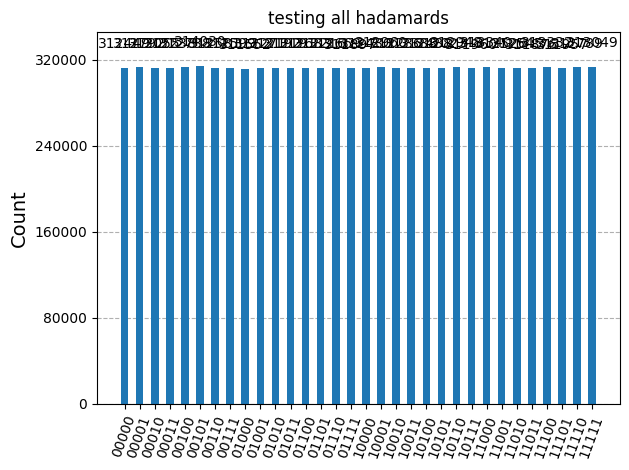

In [67]:
start = time.time()

job = simulator.run(hadamard_circuit, shots = 10000000)
result = job.result()
end = time.time()
print(f"This trial took {end - start} seconds")
plot_histogram(result.get_counts(), title="testing all hadamards")

Note that the time to run each trial is roughly consistent, and thus the amount of time the entire code takes is linearly proportional to time. 

Now lets try to estimate the probabilities instead of trying to determine them by measuring.

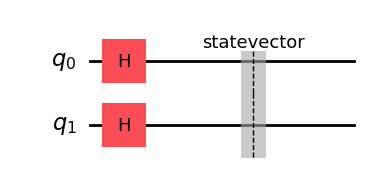

In [84]:
def super_hadamard(circuit, start_q, end_q): # uses qubit index, so start at q0
    for qubit in range(start_q, end_q+1):
        circuit.h(qubit)

hadamard_theory_tester = QuantumCircuit(2)
super_hadamard(hadamard_theory_tester, 0,1) 
hadamard_theory_tester.save_statevector()
#hadamard_tester.measure_all() We do NOT want to measure in order to obtain the statevector, so ignore this line
hadamard_theory_tester.draw("mpl")

Result(backend_name='aer_simulator_statevector', backend_version='0.17.0', job_id='3b97698d-2ec1-4edd-95b3-9d059b36d925', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(statevector=Statevector([0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j],
            dims=(2, 2))), header={'creg_sizes': [], 'global_phase': 0.0, 'memory_slots': 0, 'n_qubits': 2, 'name': 'circuit-212', 'qreg_sizes': [['q', 2]], 'metadata': {}}, status=DONE, seed_simulator=2445966521, metadata={'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 8, 'parallel_shots': 1, 'noise': 'ideal', 'batched_shots_optimization': False, 'remapped_qubits': False, 'active_input_qubits': [0, 1], 'device': 'CPU', 'time_taken': 5.3083e-05, 'measure_sampling': True, 'num_clbits': 0, 'max_memory_mb': 8192, 'input_qubit_map': [[1, 1], [0, 0]], 'num_qubits': 2, 'method': 'statevector', 'required_memory_mb': 1, 'result_subtypes': {'statevector': 'single'}, 'result_typ

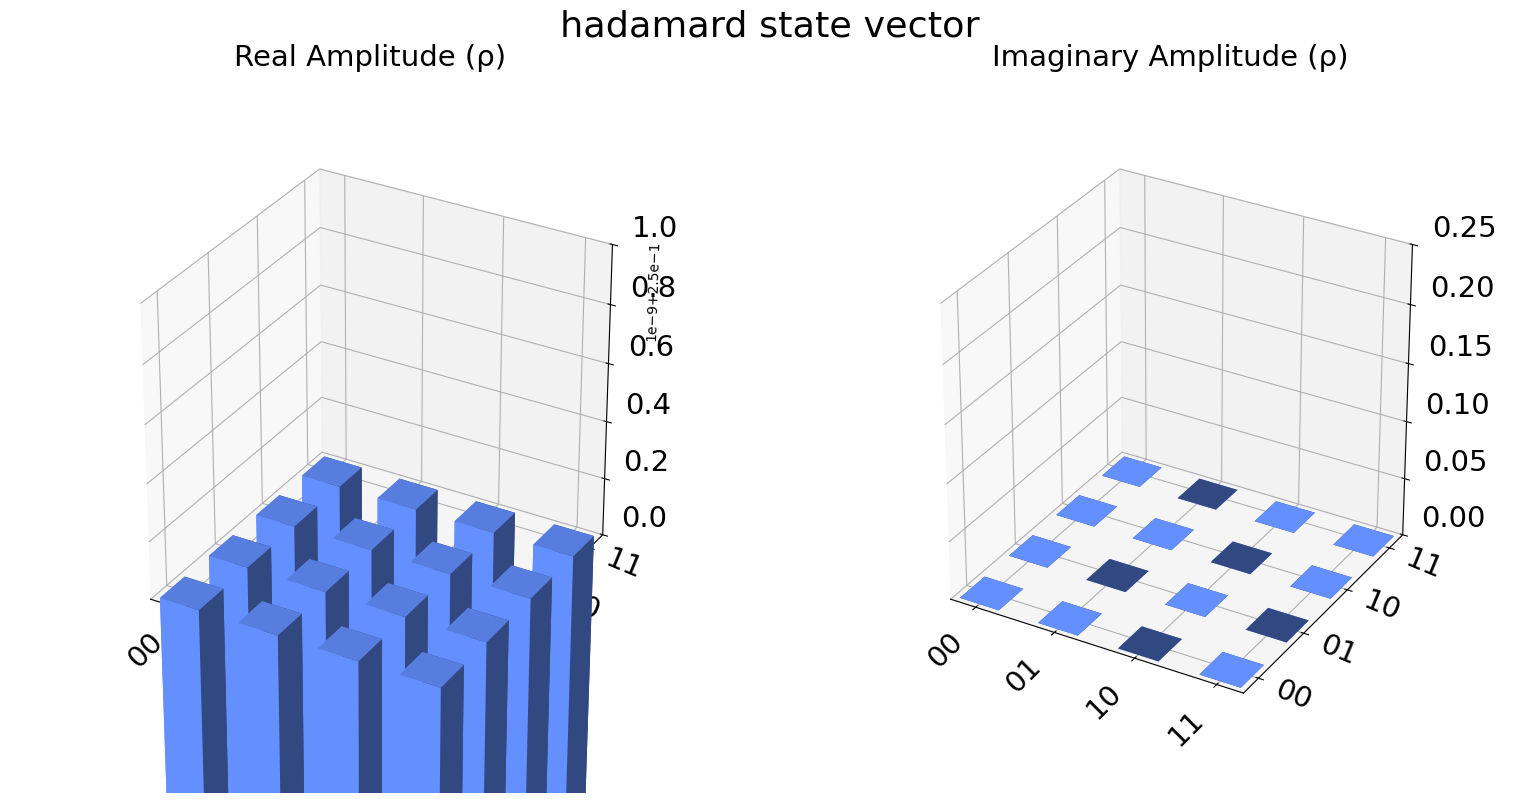

In [90]:
simulator = AerSimulator(method='statevector')
hadamard_theory_tester = transpile(hadamard_theory_tester, simulator)
result = simulator.run(hadamard_theory_tester).result()
print(result)
statevector = result.get_statevector()
plot_state_city(statevector,title="hadamard state vector")

Okay so, I'm not sure why the bars are not working properly, but the statevector values are correct as you can see in the block of text printed in the output. Specifically look where it says `data=ExperimentResultData(statevector=Statevector([0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])`. There should be no imaginary, and we should have $\frac{1}{\sqrt{2}} * \frac{1}{\sqrt{2}} = \frac{1}{2}$ as the coefficient of the basis states, which aligns with the statevector's values.

So, to recap. When using Qiskit Aer, you have two options. Either measure using sampling, or estimate using `save_statevector()` midway through the circuit. There might be a way to mix the two, but that might be a waste of computational resources. To do either method do the following:

- For Sampling: Create the your circuit as normal, then at the end add measurements on every qubit to measure when running. Then activate QiskitAer using `simulator = AerSimulator()`. Then transpile your ciruit in order to ensure everything works by using `transpiled_circuit = transpile(original_circuit, simulator)`. Then run the simualtor by using `job = simulator.run(transpiled_circuit)` and you can adjust the number of shots by adding an argument called `shots` and assigning a value to it. To extract results, use `job.result().get_counts()` to find the number of times a certain bitstring was sampled then one can graph this using  `plot_histogram()`.
- For Viewing Statevectors: Create the circuit as normal, then wherever you want to determine the value of the statevector add `original_circuit.save_statevector()`. DO NOT ADD ANY MEASUREMENTS!!! Unless your idea is to determine the statevector after measuring things, like it is used in some algorithms like Shor's. If using multiple, make sure to assign these to different variables such as `psi1` and `psi2`. Then activate QiskitAer and transpile like normal. Then run the simulator using `job = simulator.run(transpiled_circuit)`. You can then run `plot_state_city(simulator.run(transpiled_circuit).result().get_statevector())` to plot it on a graph.